This script:

- Filters variant data using per-drug significance thresholds from running whole genome GWAS with the isolates and phenotype.
- Builds a combined summary table in memory.
- Generates a Venn diagram and bar chart.
- Prints pairwise shared variants and shared genes.

In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from venny4py.venny4py import venny4py
from itertools import combinations

In [3]:
drugs = ['CAZ', 'CIP', 'MEM', 'TOB']

In [4]:
input_dir = './'
patterns_base_path = 'wGWAS/'
threshold_script = 'count_patterns.py'

In [5]:
# Get per-drug significance thresholds
drug_thresholds = {}
for drug in drugs:
    try:
        result = subprocess.run(
            ['python3', threshold_script, '--threshold', f'{patterns_base_path}{drug}_patterns'],
            capture_output=True, text=True, check=True
        )
        threshold_value = float(result.stdout.strip())
        drug_thresholds[drug] = threshold_value
    except subprocess.CalledProcessError as e:
        print(f"Error running threshold script for {drug}: {e}")

In [6]:
# Load and filter data based on thresholds computed using whole genome GWAS patterns
variant_to_drugs = defaultdict(set)
dfs = []

for drug in drugs:
    threshold = drug_thresholds.get(drug)
    drug_dir = os.path.join(input_dir, drug)

    if threshold is None:
        continue

    if os.path.isdir(drug_dir):
        for filename in os.listdir(drug_dir):
            filepath = os.path.join(drug_dir, filename)
            if os.path.isfile(filepath):
                df = pd.read_csv(filepath, sep='\t')

                if 'lrt-pvalue' in df.columns:
                    df = df[df['lrt-pvalue'] < threshold]
                else:
                    continue

                gene_name = filename.split('.')[0]
                df['variant'] = df['variant'].apply(lambda x: gene_name + '_' + '_'.join(x.split('_')[2:]))

                for var in df['variant']:
                    variant_to_drugs[var].add(drug)

                df['drug'] = drug
                dfs.append(df)

full_df = pd.concat(dfs, axis=0, ignore_index=True)
full_df['drug(s)'] = full_df['variant'].apply(lambda x: ', '.join(sorted(variant_to_drugs[x])))
full_df = full_df.drop(columns=['drug'])
full_df = full_df.drop_duplicates(subset='variant')
final_df = full_df.set_index('variant')
final_df.head(3)

,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,variant_h2,k-samples,nk-samples,notes,drug(s)
variant,,,,,,,,,,
PA14_RS12590_2678530_CGGTCAAC_GCGTTAAG,0.1070,4.860000e-08,4.990000e-09,2.36,0.395,0.283,"CH5551,CH5666,CH5688,CH5695,ESP064,ESP069,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,"CAZ, MEM"
PA14_RS12620_2683944_C_G,0.0704,6.650000e-06,4.460000e-08,2.49,0.447,0.266,"CF592_Iso2,CH5464,CH5551,CH5666,CH5695,ESP064,...","CF609_Iso3,CH2500,CH2502,CH2522,CH2527,CH2543,...",NaN,CAZ
PA14_RS12620_2684001_CGGC_AGGG,0.0801,8.660000e-07,3.610000e-08,2.41,0.430,0.267,"CH5464,CH5551,CH5666,CH5695,ESP064,ESP069,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,"CAZ, MEM"


In [7]:
#get gene infor for variants 
genes = pd.read_csv('PA14_genes.txt', sep = '\t', index_col ='locus_tag')
genes.head(3) 

sig_var = final_df.copy().reset_index()
sig_var.index = ['_'.join(v.split('_')[:2]) for v in sig_var['variant']]
sig_var['position'] = [p.split('_')[2] for p in sig_var['variant']]
sig_var['SNP'] = ['>'.join(s.split('_')[3:]) for s in sig_var['variant']]
sig_df = pd.merge(sig_var, genes['gene_name'], left_index = True, right_index = True, how = 'left')
#sig_df.to_csv('variantinfo_pa.tsv', sep='\t')
sig_df

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,variant_h2,k-samples,nk-samples,notes,drug(s),position,SNP,gene_name
PA14_RS00075,PA14_RS00075_17265_C_T,0.0437,1.420000e-07,1.730000e-11,4.08,0.589,0.323,"F1697,F1724,F1741,F1746,F1747,F1795,F1810,F186...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,"CAZ, MEM",17265,C>T,NaN
PA14_RS01180,PA14_RS01180_259412_C_T,0.0850,2.700000e-09,7.280000e-08,3.28,0.597,0.261,"CH2608,CH2674,CH2748,CH3290,CH5052,CH5688,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,MEM,259412,C>T,NaN
PA14_RS01325,PA14_RS01325_293136_T_C,0.0194,1.990000e-08,1.180000e-07,8.76,1.620,0.257,"F1752,F1760,F1789,F1812,F1821,F2054,F2176,ZG50...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,TOB,293136,T>C,NaN
PA14_RS01325,PA14_RS01325_293145_C_T,0.0194,1.990000e-08,1.180000e-07,8.76,1.620,0.257,"F1752,F1760,F1789,F1812,F1821,F2054,F2176,ZG50...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,TOB,293145,C>T,NaN
PA14_RS01330,PA14_RS01330_293742_A_G,0.0340,1.430000e-04,4.100000e-09,5.88,0.979,0.285,"ESP064,ESP069,ESP078,ESP084,F1752,F1760,F1789,...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,TOB,293742,A>G,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA14_RS30960,PA14_RS30960_5346376_T_C,0.1260,2.230000e-32,6.340000e-08,2.99,0.543,0.263,"CH2543,CH2560,CH2591,CH2608,CH2639,CH2657,CH26...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,TOB,5346376,T>C,NaN
PA14_RS31220,PA14_RS31220_1929282_A_G,0.0850,2.700000e-09,7.280000e-08,3.28,0.597,0.261,"CH2608,CH2674,CH2748,CH3290,CH5052,CH5688,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,MEM,1929282,A>G,NaN
PA14_RS31230,PA14_RS31230_1936761_T_C,0.0850,2.700000e-09,7.280000e-08,3.28,0.597,0.261,"CH2608,CH2674,CH2748,CH3290,CH5052,CH5688,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,MEM,1936761,T>C,NaN
PA14_RS31230,PA14_RS31230_1936773_T_C,0.0850,2.700000e-09,7.280000e-08,3.28,0.597,0.261,"CH2608,CH2674,CH2748,CH3290,CH5052,CH5688,ESP0...","CF592_Iso2,CF609_Iso3,CH2500,CH2502,CH2522,CH2...",NaN,MEM,1936773,T>C,NaN


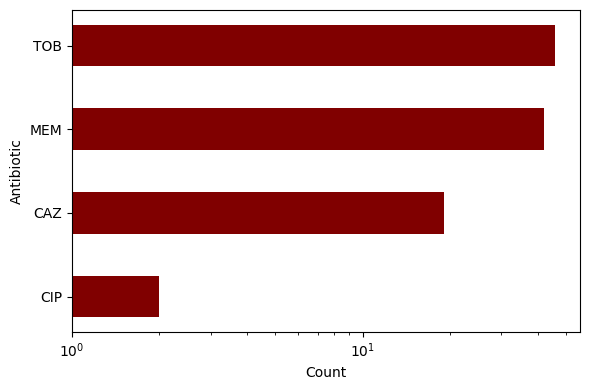


Unique resistance genes per drug:
TOB    46
MEM    42
CAZ    19
CIP     2
dtype: int64


In [8]:
df = final_df.copy()

# Initialize dictionary to hold unique genes per drug
drug_to_genes = defaultdict(set)

# Loop through each row
for idx, row in df.iterrows():
    variant = idx  # assuming 'variant' is the index
    gene = '_'.join(variant.split('_')[:2])  # extract gene from variant
    drugs = row['drug(s)'].split(', ')

    for drug in drugs:
        drug_to_genes[drug].add(gene)

# Count unique genes per drug
gene_counts = {drug: len(genes) for drug, genes in drug_to_genes.items()}

# Convert to pandas Series and sort
gene_counts_series = pd.Series(gene_counts).sort_values(ascending=False)

# Extract sorted values for plotting (reversed for descending barh)
sorted_drugs = gene_counts_series.index[::-1].tolist()
sorted_values = gene_counts_series.values[::-1].tolist()

# Plotting
plt.figure(figsize=(6, 4))
plt.barh(sorted_drugs, sorted_values, height=0.5, color="maroon")
plt.xlabel('Count')
plt.ylabel('Antibiotic')
plt.xscale('log')
plt.xlim(1, max(sorted_values) + 10)
plt.tight_layout()
plt.show()

# Print the counts
print("\nUnique resistance genes per drug:")
print(gene_counts_series)


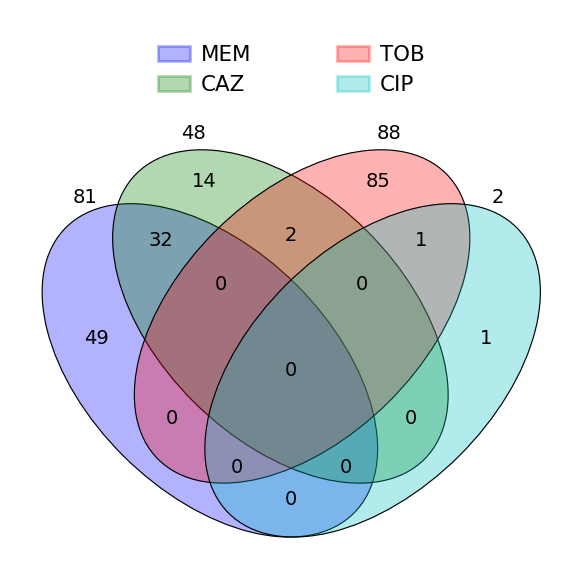

In [9]:
# Generate Venn diagram of shared variants
drug_variant_sets = defaultdict(set)
for variant, drugset in variant_to_drugs.items():
    for drug in drugset:
        drug_variant_sets[drug].add(variant)

venny4py(drug_variant_sets, ext='svg')
#plt.savefig("shared_variants.svg", dpi=300)
plt.show()

In [3]:
drugs = ['CAZ', 'CIP', 'MEM', 'TOB']

In [10]:
# Some summary stats
print("Total unique variants (Venn):", len(set().union(*drug_variant_sets.values())))
print("Total unique variants in final table:", final_df.shape[0])

print("\nNumber of variants per drug:")
for drug in drugs:
    print(f"  {drug}: {len(drug_variant_sets[drug])}")

Total unique variants (Venn): 184
Total unique variants in final table: 184

Number of variants per drug:
  TOB: 88


In [11]:
print("\nShared variants between each pair of drugs:")
for drug1, drug2 in combinations(drugs, 2):
    shared_variants = sorted(drug_variant_sets[drug1] & drug_variant_sets[drug2])
    print(f"  {drug1} & {drug2}: {len(shared_variants)} shared variants")
    print(f"    Variants: {', '.join(shared_variants)}")


Shared variants between each pair of drugs:


In [12]:
# Load AMR reference
amr = pd.read_csv('BVBRC_sp_gene_pa.csv', index_col='Gene')
amr = amr[amr['Property'] == 'Antibiotic Resistance']  # Keep only resistance genes
amr_genes = set(amr.index)

In [13]:
gene_map = genes.copy().reset_index()  

def extract_locus(variant_id):
    return '_'.join(variant_id.split('_')[:2])

cis_amr_summary = {}

for drug in drugs:
    # Get significant variants for this drug
    variants = final_df[final_df["drug(s)"].str.contains(drug)].index
    loci = {extract_locus(v) for v in variants}

    # Get gene names for those locus tags
    matched_genes = gene_map[gene_map["locus_tag"].isin(loci)]
    matched_genes = matched_genes.dropna(subset=["gene_name"])  # Drop missing gene names

    # Match gene_name to AMR index
    matched_amr = matched_genes[matched_genes["gene_name"].isin(amr.index)]

    # Join in AMR info
    enriched = matched_amr.merge(amr, left_on="gene_name", right_index=True, how="left")

    cis_amr_summary[drug] = enriched
    print(f"\n{drug}: {len(enriched)} significant AMR genes found")
    display(enriched[[
        "locus_tag", "gene_name", "Product", "Classification", "Function", "strand", "start", "end"
    ]])



TOB: 0 significant AMR genes found


,locus_tag,gene_name,Product,Classification,Function,strand,start,end
